In [1]:
import pandas as pd
import numpy as np
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.dates as DateFormatter
from datetime import datetime

In [2]:
def logistic_growth(t,L,k,Xo):
    #return L / (1+ 999*math.exp(-2*t))
    return L/(1+np.exp(-(t-Xo)/k))

#SIR Model based on https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def plot_curves(startdate,k,Xo,L,N,I0,beta,gamma): # A grid of time points (in days)
    t = np.linspace(0, 360, 360)
    R0=0
    S0=N-I0-R0
    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T

    t = np.linspace(0, 360, 360)
    cumulative=[]
    
    for step in t:
        cumulative.append(logistic_growth(step,L,k,Xo))
        
    dailySIRarray=[]
    for i in range(0,len(I)):
        if (I[i]-I[i-1])<0:
            dailySIRarray.append(0)
        else:
            dailySIRarray.append(I[i]-I[i-1])
        
    cumulative_array = np.array(cumulative)

    cumulative_array_shifted = np.insert(np.delete(cumulative_array, -1), 0, 0)

    daily_array = cumulative_array - cumulative_array_shifted  # the desired output in OP

    TotalCurves=pd.DataFrame(dailySIRarray,columns=["SIR_Model_Daily"])
    TotalCurves["SIR_Model_Cumulative"]=TotalCurves["SIR_Model_Daily"].cumsum()
    TotalCurves["Logistic_Growth_Curve_Daily"]=daily_array
    TotalCurves["Logistic_Growth_Curve_Cumulative"]=cumulative_array

    datelist = pd.date_range(startdate, periods=360).tolist()

    TotalCurves['Date']=datelist
    TotalCurves['Date']=TotalCurves['Date'].astype(str)
    TotalCurves.index=datelist
    
    return TotalCurves

In [3]:
startdate='2021-01-01'

#Logistic Growth Curve
k=10 # (steepness)
Xo=120 # (mid point)
L=15000 #(Max Infected Cumulative Cases)

#SIR Model 
#Adapted from https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
N = 50000 # Total population, N
I0 =1 # Initial number of infected individuals
R0 = 0 # Initial number of recovered individuals
S0 = N - I0 - R0 # Everyone else, S0, is susceptible to infection initially.
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta=0.14
gamma = 1./20

<AxesSubplot:title={'center':'Cumulative No Of Cases'}>

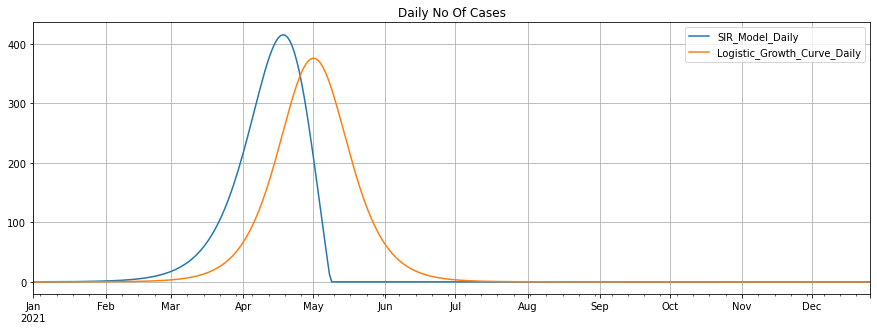

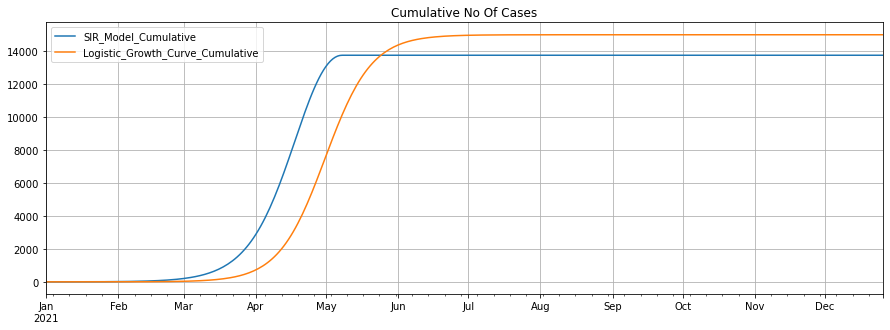

In [4]:
TotalCurves=plot_curves(startdate,k,Xo,L,N,I0,beta,gamma)
TotalCurves[["SIR_Model_Daily","Logistic_Growth_Curve_Daily"]].plot(figsize=(15,5),grid=True,title="Daily No Of Cases")
TotalCurves[["SIR_Model_Cumulative","Logistic_Growth_Curve_Cumulative"]].plot(figsize=(15,5),grid=True,title="Cumulative No Of Cases")

In [5]:
LogisticCurve_Cumul_Max=TotalCurves['Logistic_Growth_Curve_Cumulative'].max()
LogisticCurve_Cumul_Max_Date=TotalCurves.index[TotalCurves['Logistic_Growth_Curve_Cumulative']==LogisticCurve_Cumul_Max].tolist()[0].strftime('%Y-%m-%d')
LogisticCurve_Daily_Max=TotalCurves['Logistic_Growth_Curve_Daily'].max()
LogisticCurve_Daily_Max_Date=TotalCurves.index[TotalCurves['Logistic_Growth_Curve_Daily']==LogisticCurve_Daily_Max].tolist()[0].strftime('%Y-%m-%d')

SIR_Cumul_Max=TotalCurves['SIR_Model_Cumulative'].max()
SIR_Cumul_Max_Date=TotalCurves.index[TotalCurves['SIR_Model_Cumulative']==SIR_Cumul_Max].tolist()[0].strftime('%Y-%m-%d')

SIR_Daily_Max=TotalCurves['SIR_Model_Daily'].max()
SIR_Daily_Max_Date=TotalCurves.index[TotalCurves['SIR_Model_Daily']==SIR_Daily_Max].tolist()[0].strftime('%Y-%m-%d')

stringmessage1=f"Estimated Max Cumulative Cases Of {round(LogisticCurve_Cumul_Max,0)} Occurs On {LogisticCurve_Cumul_Max_Date}"
stringmessage2=f"Estimated Max Daily Cases Of {round(LogisticCurve_Daily_Max,0)} Occurs On {LogisticCurve_Daily_Max_Date}"
stringmessage3=f"Estimated Max Cumulative Cases Of {round(SIR_Cumul_Max,0)} Occurs On {SIR_Cumul_Max_Date}"
stringmessage4=f"Estimated Max Daily Cases Of {round(SIR_Daily_Max,0)} Occurs On {SIR_Daily_Max_Date}"
stringmessage="Logistic Growth Model Estimates:"+"<br>"+stringmessage1+"<br>"+stringmessage2+"<br><br>"+"SIR Model Estimates:"+"<br>"+stringmessage3+"<br>"+stringmessage4
stringmessage

'Logistic Growth Model Estimates:<br>Estimated Max Cumulative Cases Of 15000.0 Occurs On 2021-12-26<br>Estimated Max Daily Cases Of 376.0 Occurs On 2021-05-01<br><br>SIR Model Estimates:<br>Estimated Max Cumulative Cases Of 13756.0 Occurs On 2021-05-08<br>Estimated Max Daily Cases Of 415.0 Occurs On 2021-04-18'

In [6]:
#(Heavily) adapted from https://github.com/nipunbatra/mpld3-flask

from flask import Flask, render_template, json, request
import numpy as np

import matplotlib
import json
import random

matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()

from threading import Lock
lock = Lock()
import datetime
import mpld3
from mpld3 import plugins

# # Setting up matplotlib sytles using BMH
# s = json.load(open("./static/bmh_matplotlibrc.json"))
# matplotlib.rcParams.update(s)

def draw_fig(fig_type,startdate,k,Xo,L,N,I0,beta,gamma):
    
    #startdate='2019-03-01'

    #Logistic Growth Curve
    #k=10 # (steepness)
    #Xo=70 # (mid point)
    #L=9000 #(Max Infected Cumulative Cases)

    #SIR Model 
    #N = 1200 # Total population, N
    #I0 =1 # Initial number of infected individuals
    R0 = 0 # Initial number of recovered individuals
    S0 = N - I0 - R0 # Everyone else, S0, is susceptible to infection initially.
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    #beta=0.2
    #gamma = 1./10 
    
    css = """
table
{
  border-collapse: collapse;
}
th
{
  color: #ffffff;
  background-color: #000000;
}
td
{
  background-color: #cccccc;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: right;
}
"""
    
    """Returns html equivalent of matplotlib figure

    Parameters
    ----------
    fig_type: string, type of figure
            one of following:
                    * line
                    * bar

    Returns
    --------
    d3 representation of figure
    """
    
    TotalCurves=plot_curves(startdate,k,Xo,L,N,I0,beta,gamma)
    
    LogisticCurve_Cumul_Max=TotalCurves['Logistic_Growth_Curve_Cumulative'].max()
    LogisticCurve_Cumul_Max_Date=TotalCurves.index[TotalCurves['Logistic_Growth_Curve_Cumulative']==LogisticCurve_Cumul_Max].tolist()[0].strftime('%Y-%m-%d')
    LogisticCurve_Daily_Max=TotalCurves['Logistic_Growth_Curve_Daily'].max()
    LogisticCurve_Daily_Max_Date=TotalCurves.index[TotalCurves['Logistic_Growth_Curve_Daily']==LogisticCurve_Daily_Max].tolist()[0].strftime('%Y-%m-%d')

    SIR_Cumul_Max=TotalCurves['SIR_Model_Cumulative'].max()
    SIR_Cumul_Max_Date=TotalCurves.index[TotalCurves['SIR_Model_Cumulative']==SIR_Cumul_Max].tolist()[0].strftime('%Y-%m-%d')

    SIR_Daily_Max=TotalCurves['SIR_Model_Daily'].max()
    SIR_Daily_Max_Date=TotalCurves.index[TotalCurves['SIR_Model_Daily']==SIR_Daily_Max].tolist()[0].strftime('%Y-%m-%d')

    stringmessage1=f"Estimated Max Cumulative Cases Of {round(LogisticCurve_Cumul_Max,0)} Occurs On {LogisticCurve_Cumul_Max_Date}"
    stringmessage2=f"Estimated Max Daily Cases Of {round(LogisticCurve_Daily_Max,0)} Occurs On {LogisticCurve_Daily_Max_Date}"
    stringmessage3=f"Estimated Max Cumulative Cases Of {round(SIR_Cumul_Max,0)} Occurs On {SIR_Cumul_Max_Date}"
    stringmessage4=f"Estimated Max Daily Cases Of {round(SIR_Daily_Max,0)} Occurs On {SIR_Daily_Max_Date}"
    stringmessage="Logistic Growth Model Estimates:"+"<br>"+stringmessage1+"<br>"+stringmessage2+"<br><br>"+"SIR Model Estimates:"+"<br>"+stringmessage3+"<br>"+stringmessage4+"<br"
    
    x=TotalCurves["Date"]
    
    fig, ax = plt.subplots()

    
    if fig_type == "daily":
        y=TotalCurves["SIR_Model_Daily"]
        z=TotalCurves["Logistic_Growth_Curve_Daily"]
        ax.plot(x, y)
        ax.plot(x, z)
        
        df=pd.DataFrame(zip(x,y,z),columns=["Date","SIR_Model","Logistic_Growth_Model"])
        labels = []
        for i in range(len(x)):
            label = df.iloc[[i], :].T
            label.columns = ['Row {0}'.format(i)]
            # .to_html() is unicode; so make leading 'u' go away with str()
            labels.append(str(label.to_html()))

        points = ax.plot(df.index, df.SIR_Model ,'o', color='b',
                     ls='-', ms=5, markerfacecolor='None',markeredgecolor='None')

        tooltip1 = plugins.PointHTMLTooltip(points[0], labels,voffset=10, hoffset=10, css=css)

        plugins.connect(fig, tooltip1)
    
    elif fig_type=="cumulative":
        y=TotalCurves["SIR_Model_Cumulative"]
        z=TotalCurves["Logistic_Growth_Curve_Cumulative"]
        ax.plot(x, y)
        ax.plot(x, z)
        
        df=pd.DataFrame(zip(x,y,z),columns=["Date","SIR_Model","Logistic_Growth_Model"])
        labels = []
        for i in range(len(x)):
            label = df.iloc[[i], :].T
            label.columns = ['Row {0}'.format(i)]
            # .to_html() is unicode; so make leading 'u' go away with str()
            labels.append(str(label.to_html()))

        points = ax.plot(df.index, df.SIR_Model ,'o', color='b',
                     ls='-', ms=5, markerfacecolor='None',markeredgecolor='None')

        tooltip1 = plugins.PointHTMLTooltip(points[0], labels,voffset=10, hoffset=10, css=css)

        plugins.connect(fig, tooltip1)
    
    return mpld3.fig_to_html(fig)+stringmessage

# app = Flask(__name__)

app = Flask(__name__)

@app.route('/service-worker.js')
def sw():
    #return app.send_static_file('service-worker.js')
    return app.send_static_file('service-worker.js'), 200, {'Content-Type': 'text/javascript'}

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/main')
def main():
    
    return render_template('main.html')


@app.route('/query', methods=['POST'])
def query():
    data = json.loads(request.data)
    fig_type=data['plot_type']
    startdate=data['StartDate']
    k=int(data['LogisticSteepness'])
    Xo=int(data['LogisticMidPoint'])
    L=int(data['LogisticMaxInfected'])
    N=int(data['SIRTotalPop'])
    I0=int(data['SIRI0'])
    beta=float(data['SIRBeta'])
    gamma=float(data['SIRGamma'])
    return draw_fig(fig_type,startdate,k,Xo,L,N,I0,beta,gamma)

if __name__ == '__main__':
    app.run(debug=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [31/Jan/2021 22:45:38] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [31/Jan/2021 22:45:39] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [31/Jan/2021 22:45:39] "GET /service-worker.js HTTP/1.1" 200 -
127.0.0.1 - - [31/Jan/2021 22:45:41] "GET /service-worker.js HTTP/1.1" 200 -
127.0.0.1 - - [31/Jan/2021 22:45:46] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [31/Jan/2021 22:47:29] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [31/Jan/2021 22:47:31] "GET /service-worker.js HTTP/1.1" 200 -
127.0.0.1 - - [31/Jan/2021 22:47:37] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [31/Jan/2021 22:47:46] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [31/Jan/2021 22:47:48] "GET /static/images/icon-64.png HTTP/1.1" 200 -
127.0.0.1 - - [31/Jan/2021 22:47:48] "GET /static/images/icon-512.png HTTP/1.1" 200 -
127.0.0.1 - - [31/Jan/2021 22:48:46] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [31/Jan/2021 22:49:38] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [31/Jan/2021 22:49:47] "GET /service-worker.